# Elite Dangerous Core Mining - Segmentation Detection Pipeline

Trains YOLOv8 **instance segmentation** models to identify and outline core
asteroids in Elite Dangerous screenshots in real time. Segmentation models draw
a polygon mask over each detected core rather than just a rectangle - a better
fit for the irregular "popcorn" asteroid shapes.

## Labeling in Roboflow

Use the **Smart Select (SAM2/SAM3) polygon tool** exactly as you are doing.
Click the asteroid and confirm the auto-traced outline. The SAM model used for
annotation is Roboflow-internal and has nothing to do with your trained model.

When exporting, choose: **YOLOv8 -> Segmentation** format.
The label files will contain polygon point coordinates instead of just a bbox.

## Dataset structure

```
datasets/
  ice/
    images/    <- all .png or .jpg screenshots, flat - no subfolders
    labels/    <- matching YOLO segmentation .txt files
  metallic/
    images/
    labels/
  rocky/
    images/
    labels/
  metal_rich/  <- metal-rich rings (Painite, Platinum - NOT the same as metallic!)
    images/
    labels/
  unified/     <- optional: all ring types combined
    images/
    labels/
```

YOLO segmentation label format (one line per core):
`0 x1 y1 x2 y2 ... xn yn`
Class index (0 = core) followed by normalized polygon point pairs (all 0.0-1.0).
Roboflow exports this automatically when you pick the segmentation export format.

## Models trained

We train and compare four YOLOv8-seg model sizes per ring type:
- yolov8n-seg  fastest, smallest (~3.4M params)
- yolov8s-seg  good balance (~11.8M params)
- yolov8m-seg  higher accuracy (~27.3M params)
- yolov8l-seg  best accuracy, slower inference (~46.5M params)

All four fit on RTX 3070 8GB at batch=16. K-fold cross-validation gives reliable
metric estimates without requiring manual train/val splits.

## Ring types

- **ice**: icy rings - "popcorn" shaped cores, yield Void Opals / Low Temp Diamonds
- **metallic**: metallic rings - teardrop shaped cores
- **rocky**: rocky rings - roughly spherical cores
- **metal_rich**: metal-rich rings - "dog turd" shaped cores, yield Painite / Platinum

Each ring type has exactly one asteroid shape that can contain a core. Training
separate specialist models per ring type exploits this constraint.


## 1. Install dependencies

Run once. Restart the kernel after.

In [1]:
import subprocess, sys

packages = [
    "ultralytics>=8.2.0",
    "opencv-python>=4.9.0",
    "pyyaml>=6.0.1",
    "matplotlib>=3.9.0",
    "scikit-learn>=1.5.0",
    "pandas>=2.2.0",
    "Pillow>=10.3.0",
    "onnx>=1.16.0",
    "onnxruntime-gpu>=1.18.0",
]

subprocess.run(
    [sys.executable, "-m", "pip", "install", "--quiet"] + packages,
    check=True,
)
print("All packages installed.")


All packages installed.


## 2. Imports and GPU check

In [2]:
import os
import sys
import json
import math
import shutil
import csv
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection

from pathlib import Path
from datetime import datetime
from collections import defaultdict

import torch
from ultralytics import YOLO
from sklearn.model_selection import KFold

print(f"Python:  {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    gpu = torch.cuda.get_device_properties(0)
    vram_gb = gpu.total_memory / 1024 ** 3
    print(f"GPU: {gpu.name}")
    print(f"VRAM: {vram_gb:.1f} GB")
    if vram_gb < 6:
        print("WARNING: less than 6 GB VRAM - reduce BATCH_SIZE to 8 if training crashes")
else:
    print("WARNING: no GPU found. Training on CPU will be very slow.")
    print("Reinstall PyTorch with CUDA support:")
    print("  pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121")


Python:  3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
PyTorch: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3070
VRAM: 8.0 GB


## 3. Configuration

In [4]:
# ---- MAIN CONFIG - edit this before running ----

# Ring types to train. Remove any you don't have data for yet.
# metal_rich = metal-rich rings (different from metallic rings - different core
# shape and commodities like Painite and Platinum). Add images for each type
# to datasets/<ring_type>/images/ as you collect them.
RING_TYPES = ["ice"] #"metallic", "rocky", "metal_rich", "unified"]

# Segmentation model sizes to compare per ring type.
# All four fit on RTX 3070 8GB at batch=16.
# n=fastest, s=balanced, m=good accuracy, l=best accuracy
# YOLOv8-seg: battle-tested, well documented, good baseline
# YOLO11-seg: newer Ultralytics architecture, better accuracy/speed tradeoff
#             than YOLOv8 on most benchmarks. Use "yolo11x-seg" for max accuracy.
# Note: YOLOv26 is Roboflow's proprietary cloud model - not available via
#       Ultralytics, so we cannot train it locally.
MODEL_SIZES = [
    "yolov8n-seg", "yolov8s-seg", "yolov8m-seg", "yolov8l-seg",
    "yolo11n-seg",  "yolo11s-seg",  "yolo11m-seg",  "yolo11l-seg",
]

# Number of cross-validation folds.
# 3 is best when you have fewer than ~30 images per ring type (such as early in
# the project). Increase to 5 once you have 50+ images per ring type.
# With K=3: ~67% train / ~33% val per fold - more stable with small datasets.
# With K=5: ~80% train / ~20% val - better estimate but needs more data.
K_FOLDS = 5

# Training hyperparameters
IMG_SIZE    = 640   # YOLO standard input size
EPOCHS      = 100   # max epochs per fold (early stopping usually fires earlier)
BATCH_SIZE  = 16    # reduce to 8 if you get CUDA out-of-memory errors
PATIENCE    = 20    # stop early if val mAP doesn't improve for this many epochs

# Confidence threshold for inference (0.0 - 1.0)
# 0.4 is a good starting point. Tune based on real-game performance.
CONF_THRESHOLD = 0.6

# Mask overlay alpha for visualization (0=transparent, 1=opaque)
MASK_ALPHA = 0.45

# Core highlight color in BGR for OpenCV visualization
MASK_COLOR_BGR = (0, 255, 128)   # bright green

# We only detect one class.
CLASS_NAMES = ["core"]

# Folder layout
DATASET_ROOT = Path("datasets")
RUNS_ROOT    = Path("runs")
EXPORTS_ROOT = Path("exports")
CV_TMP_ROOT  = Path("cv_tmp")

print("Config loaded.")
print(f"Ring types: {RING_TYPES}")
print(f"Model sizes: {MODEL_SIZES}")
print(f"K-folds: {K_FOLDS}")
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
print(f"Device: {device_name}")


Config loaded.
Ring types: ['ice']
Model sizes: ['yolov8n-seg', 'yolov8s-seg', 'yolov8m-seg', 'yolov8l-seg', 'yolo11n-seg', 'yolo11s-seg', 'yolo11m-seg', 'yolo11l-seg']
K-folds: 5
Device: NVIDIA GeForce RTX 3070


## 4. Create dataset folder structure

In [5]:
def create_dataset_structure():
    """Create flat image and label folders for each ring type."""
    for ring_type in RING_TYPES:
        (DATASET_ROOT / ring_type / "images").mkdir(parents=True, exist_ok=True)
        (DATASET_ROOT / ring_type / "labels").mkdir(parents=True, exist_ok=True)

    RUNS_ROOT.mkdir(exist_ok=True)
    EXPORTS_ROOT.mkdir(exist_ok=True)
    CV_TMP_ROOT.mkdir(exist_ok=True)

    print("Folder structure created. Drop your files here:\n")
    for ring_type in RING_TYPES:
        tag = ""
        if ring_type == "metal_rich":
            tag = "  (metal-rich rings - Painite, Platinum cores)"
        elif ring_type == "unified":
            tag = "  (all ring types combined - comparison baseline)"
        print(f"  datasets/{ring_type}/images/{tag}")
        print(f"  datasets/{ring_type}/labels/")
        print()
    print("No train/val split needed - k-fold handles it automatically.")


create_dataset_structure()


Folder structure created. Drop your files here:

  datasets/ice/images/
  datasets/ice/labels/

No train/val split needed - k-fold handles it automatically.


## 4b. Import a Roboflow augmented export

After you export from Roboflow with augmentation enabled, run this before
anything else to merge the train/valid/test folders into the flat dataset pool.

**What Roboflow augmented exports look like:**
The zip contains train/, valid/, test/ folders. Each image gets a Roboflow hash
suffix like `ice_4_jpeg.rf.2ac0638f02ccd6ae5d3d8229a1f7e77b.jpg`. All augmented
variants of `ice_4_jpeg` share that prefix before `.rf.`. The importer uses
this to group them correctly so k-fold never puts augmented variants of the
same source in both train and val simultaneously.

**Which format to download from Roboflow:**
Use **YOLOv8** from the format dropdown (not COCO, not YOLOv8 OBB, not
YOLOv11/12/26 - those are different architectures or Roboflow-proprietary).

**What this does:**
1. Copies all images + labels from train/valid/test into datasets/<ring_type>/
2. Detects augmentation groups using the `.rf.<hash>` naming convention
3. Saves aug_groups.json so k-fold can keep groups together
4. Renames label files if needed (Roboflow COCO export quirk)


In [7]:
import re as _re
from collections import defaultdict as _defaultdict


def import_roboflow_export(roboflow_export_dir, ring_type, overwrite=False):
    """
    Merge a Roboflow YOLOv8-format export into the flat datasets/<ring_type>/
    pool and write aug_groups.json for leakage-free k-fold cross-validation.

    Roboflow names augmented variants like:
      ice_4_jpeg.rf.2ac0638f02ccd6ae5d3d8229a1f7e77b.jpg  (source or variant)
    The part before .rf. is the group key. All images sharing that prefix are
    kept in the same fold during training.

    Args:
        roboflow_export_dir: path to the extracted Roboflow zip folder, e.g.
            r"C:/Downloads/EliteCoreAI.v6-dataset-yolo.yolov8"
        ring_type: which ring type this is, e.g. "ice"
        overwrite: if False, skip files already present in the destination
    """
    src_root = Path(roboflow_export_dir)
    dst_img  = DATASET_ROOT / ring_type / "images"
    dst_lbl  = DATASET_ROOT / ring_type / "labels"
    dst_img.mkdir(parents=True, exist_ok=True)
    dst_lbl.mkdir(parents=True, exist_ok=True)

    img_exts       = {".png", ".jpg", ".jpeg"}
    copied_imgs    = 0
    copied_lbls    = 0
    skipped        = 0
    missing_labels = []

    for split in ("train", "valid", "test"):
        split_img = src_root / split / "images"
        split_lbl = src_root / split / "labels"
        if not split_img.exists():
            continue

        for img_path in sorted(split_img.iterdir()):
            if img_path.suffix.lower() not in img_exts:
                continue

            dst_i = dst_img / img_path.name
            if dst_i.exists() and not overwrite:
                skipped += 1
                continue
            shutil.copy2(img_path, dst_i)
            copied_imgs += 1

            lbl_path = split_lbl / (img_path.stem + ".txt")
            if lbl_path.exists():
                shutil.copy2(lbl_path, dst_lbl / lbl_path.name)
                copied_lbls += 1
            else:
                missing_labels.append(img_path.name)

    print(f"Copied {copied_imgs} images, {copied_lbls} labels into datasets/{ring_type}/")
    if skipped:
        print(f"Skipped {skipped} already-existing files (pass overwrite=True to replace)")
    if missing_labels:
        print(f"WARNING: {len(missing_labels)} images had no label: {missing_labels[:5]}")

    # Roboflow hash pattern: <source_name>.rf.<hex_hash>
    # e.g. ice_4_jpeg.rf.2ac0638f02ccd6ae5d3d8229a1f7e77b
    # Group key = everything before .rf.
    rf_pattern = _re.compile(r"^(.+?)\.rf\.[a-f0-9]+$", _re.IGNORECASE)

    groups = _defaultdict(list)
    for img_path in sorted(dst_img.iterdir()):
        if img_path.suffix.lower() not in img_exts:
            continue
        if not (dst_lbl / (img_path.stem + ".txt")).exists():
            continue
        m = rf_pattern.match(img_path.stem)
        group_key = m.group(1) if m else img_path.stem
        groups[group_key].append(img_path.stem)

    groups_path = DATASET_ROOT / ring_type / "aug_groups.json"
    with open(groups_path, "w") as f:
        json.dump(dict(groups), f, indent=2)

    n_groups     = len(groups)
    n_augmented  = sum(1 for v in groups.values() if len(v) > 1)
    n_singletons = n_groups - n_augmented
    print(f"Augmentation groups: {n_groups} source images")
    print(f"  {n_augmented} have augmented variants, {n_singletons} are singletons")
    print(f"  Group map saved to {groups_path}")
    print(f"\nRun validate_dataset(\'{ring_type}\') to confirm everything looks good.")


# Usage - point to your extracted Roboflow zip folder:
import_roboflow_export(
    roboflow_export_dir=r"C:\Users\megakruk\Downloads\EliteCoreAI.v6-dataset-yolo.yolov8",
    ring_type="ice",
)


Copied 80 images, 80 labels into datasets/ice/
Augmentation groups: 17 source images
  7 have augmented variants, 10 are singletons
  Group map saved to datasets\ice\aug_groups.json

Run validate_dataset('ice') to confirm everything looks good.


## 5. COCO JSON to YOLO segmentation format converter

Only needed if you exported COCO JSON from Roboflow instead of YOLOv8 format.
Prefer the direct YOLOv8 segmentation export from Roboflow and skip this.

COCO segmentation format stores polygon points in the `segmentation` field.
YOLO segmentation format: `class x1 y1 x2 y2 ... xn yn` (normalized 0-1).


In [8]:
def convert_coco_seg_to_yolo(coco_json_path, output_labels_dir):
    """
    Convert a COCO-format segmentation JSON to per-image YOLO .txt label files.

    COCO segmentation stores polygon points as flat pixel-coordinate lists in
    the annotation's "segmentation" field, e.g. [x1,y1,x2,y2,...].
    YOLO segmentation format: one line per object = class followed by normalized
    polygon points: 0 x1 y1 x2 y2 ... xn yn  (all values 0.0-1.0).

    Handles quirks in Roboflow COCO exports:
    - Duplicate category entries (e.g. two entries both named "core" with
      different ids) - both are mapped to the same YOLO class index.
    - String-typed bbox values like "479.0000" instead of numbers - ignored
      for segmentation labels but handled defensively for bbox fallback.
    - Float polygon coordinates like 309.333 - cast to float before normalizing.

    If an annotation has no segmentation polygon but has a bbox, this function
    falls back to converting the bbox into a 4-point rectangle polygon so the
    annotation is not silently dropped.

    Args:
        coco_json_path: path to _annotations.coco.json
        output_labels_dir: folder where .txt files will be written
    """
    output_labels_dir = Path(output_labels_dir)
    output_labels_dir.mkdir(parents=True, exist_ok=True)

    with open(coco_json_path) as f:
        coco = json.load(f)

    cat_map = {}
    for cat in coco["categories"]:
        if cat["name"] in CLASS_NAMES:
            cat_map[cat["id"]] = CLASS_NAMES.index(cat["name"])

    if not cat_map:
        print(f"WARNING: no COCO categories match CLASS_NAMES {CLASS_NAMES}")
        print(f"Categories in file: {[c['name'] for c in coco['categories']]}")
        return 0

    images = {img["id"]: img for img in coco["images"]}

    anns_by_image = defaultdict(list)
    for ann in coco["annotations"]:
        if ann["category_id"] in cat_map:
            anns_by_image[ann["image_id"]].append(ann)

    converted = 0
    fallback_bbox = 0

    for img_id, anns in anns_by_image.items():
        img_info = images[img_id]
        W = img_info["width"]
        H = img_info["height"]
        img_name = Path(img_info["file_name"]).stem
        lines = []

        for ann in anns:
            cls = cat_map[ann["category_id"]]
            seg = ann.get("segmentation", [])

            if seg and isinstance(seg, list) and len(seg) > 0 and isinstance(seg[0], list):
                # standard COCO polygon: list of rings, take the outer ring (first one)
                points = seg[0]
            elif seg and isinstance(seg, list) and len(seg) > 0 and isinstance(seg[0], (int, float)):
                # flat list directly
                points = seg
            else:
                # no polygon - fall back to bbox as a 4-corner rectangle
                # cast to float first because Roboflow sometimes exports
                # bbox width/height as strings e.g. "479.0000"
                x, y, w, h = [float(v) for v in ann["bbox"]]
                points = [x, y, x + w, y, x + w, y + h, x, y + h]
                fallback_bbox += 1

            if len(points) < 6:
                # need at least 3 points (6 values) for a valid polygon
                continue

            # normalize all x,y pairs
            norm = []
            for i in range(0, len(points) - 1, 2):
                norm.append(f"{points[i] / W:.6f}")
                norm.append(f"{points[i+1] / H:.6f}")

            lines.append(f"{cls} " + " ".join(norm))

        if lines:
            (output_labels_dir / f"{img_name}.txt").write_text("\n".join(lines))
            converted += 1

    print(f"Converted {converted} images -> {output_labels_dir}")
    if fallback_bbox > 0:
        print(f"  {fallback_bbox} annotation(s) had no polygon and were converted from bbox instead.")
        print("  Re-label those in Roboflow using the polygon tool for best results.")
    return converted


# convert_coco_seg_to_yolo(
#     coco_json_path="./datasets/ice/_annotations.coco.json",
#     output_labels_dir="./datasets/ice/labels",
# )

## 6. Validate datasets

Checks that every image has a label, every label has valid segmentation polygon format, and the dataset is large enough for K_FOLDS.

In [11]:
import json
from pathlib import Path

def fix_label_names_after_roboflow_export(coco_json_path, labels_dir):
    """
    Roboflow renames images with a hash suffix like:
      ice_1_png.rf.QYxlvp6xCnpbhYmGF0xH.png
    but your local image files kept their original names like:
      ice_1.png

    The COCO JSON stores the original name in extra.name.
    This function renames each label .txt to match the original image stem.

    Args:
        coco_json_path: path to _annotations.coco.json
        labels_dir: folder containing the converted .txt label files
    """
    labels_dir = Path(labels_dir)

    with open(coco_json_path) as f:
        coco = json.load(f)

    renamed = 0
    skipped = 0

    for img in coco["images"]:
        roboflow_stem = Path(img["file_name"]).stem        # ice_1_png.rf.QYxlvp6xCnpbhYmGF0xH
        original_stem = Path(img["extra"]["name"]).stem    # ice_1

        src = labels_dir / f"{roboflow_stem}.txt"
        dst = labels_dir / f"{original_stem}.txt"

        if not src.exists():
            print(f"WARNING: label not found, skipping: {src.name}")
            skipped += 1
            continue

        if dst.exists() and dst != src:
            print(f"WARNING: destination already exists, skipping: {dst.name}")
            skipped += 1
            continue

        src.rename(dst)
        print(f"  {src.name} -> {dst.name}")
        renamed += 1

    print(f"\nDone. Renamed {renamed}, skipped {skipped}.")


# fix_label_names_after_roboflow_export(
#     coco_json_path="./datasets/ice/_annotations.coco.json",
#     labels_dir="./datasets/ice/labels",
# )

In [12]:
def validate_dataset(ring_type):
    """
    Check a ring type dataset for problems before training.
    Returns (stats dict, list of issue strings). Empty issues = all clear.

    Also checks that label files use segmentation format (10+ values per line)
    rather than detection format (5 values). Warns if detection labels are found
    so you know to re-export from Roboflow with the segmentation option.
    """
    img_dir = DATASET_ROOT / ring_type / "images"
    lbl_dir = DATASET_ROOT / ring_type / "labels"

    images = list(img_dir.glob("*.png")) + list(img_dir.glob("*.jpg")) + list(img_dir.glob("*.jpeg"))
    labels = list(lbl_dir.glob("*.txt"))

    img_stems = {p.stem for p in images}
    lbl_stems = {p.stem for p in labels}

    issues = []

    missing = img_stems - lbl_stems
    orphans = lbl_stems - img_stems
    if missing:
        issues.append(f"{len(missing)} image(s) have no label: {sorted(missing)[:5]}")
    if orphans:
        issues.append(f"{len(orphans)} label(s) have no image: {sorted(orphans)[:5]}")

    total_cores    = 0
    bad_lines      = 0
    detection_lbls = 0   # lines that look like detection format (5 values only)

    for lbl in labels:
        for line in lbl.read_text().strip().splitlines():
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 7:
                # less than 3 polygon points (class + 3*2=6 values minimum)
                if len(parts) == 5:
                    detection_lbls += 1
                else:
                    bad_lines += 1
                continue
            try:
                cls = int(parts[0])
                coords = [float(v) for v in parts[1:]]
                if any(v < 0 or v > 1 for v in coords):
                    bad_lines += 1
                elif cls == 0:
                    total_cores += 1
            except ValueError:
                bad_lines += 1

    if bad_lines:
        issues.append(f"{bad_lines} malformed label line(s)")
    if detection_lbls > 0:
        issues.append(
            f"{detection_lbls} label line(s) look like detection format (5 values). "
            "Re-export from Roboflow using YOLOv8 Segmentation format."
        )

    paired = len(img_stems & lbl_stems)

    groups_path = DATASET_ROOT / ring_type / "aug_groups.json"
    if groups_path.exists():
        with open(groups_path) as gf:
            aug_groups = json.load(gf)
        n_groups   = len(aug_groups)
        group_note = f" ({n_groups} source groups across {paired} augmented images)"
    else:
        n_groups   = paired
        group_note = ""

    if n_groups < K_FOLDS:
        issues.append(
            f"only {n_groups} source groups but K_FOLDS={K_FOLDS} needs >= {K_FOLDS}. "
            "Add more data or reduce K_FOLDS in config." + group_note
        )
    elif n_groups < 15 and K_FOLDS > 3:
        issues.append(
            f"only {n_groups} source groups with K_FOLDS={K_FOLDS}: "
            "consider reducing K_FOLDS to 3." + group_note
        )

    stats = {
        "images":        len(images),
        "paired":        paired,
        "source_groups": n_groups,
        "cores":         total_cores,
        "avg_cores_per_image": round(total_cores / paired, 2) if paired else 0,
    }

    print(f"\n{'=' * 44}")
    print(f"  {ring_type.upper()} dataset")
    print(f"{'=' * 44}")
    print(f"  Images:              {stats['images']}")
    print(f"  Paired (img+label):  {stats['paired']}")
    print(f"  Source groups:       {stats['source_groups']}{group_note}")
    print(f"  Total core polygons: {stats['cores']}")
    print(f"  Avg cores/image:     {stats['avg_cores_per_image']}")

    if issues:
        print("  ISSUES:")
        for iss in issues:
            print(f"    - {iss}")
    else:
        print("  All checks passed.")

    return stats, issues


for ring_type in RING_TYPES:
    validate_dataset(ring_type)



  ICE dataset
  Images:              80
  Paired (img+label):  80
  Source groups:       17 (17 source groups across 80 augmented images)
  Total core polygons: 359
  Avg cores/image:     4.49
  All checks passed.


## 7. Preview labeled images

Draws the segmentation polygons from your label files over the screenshots. Use this to confirm Roboflow exported correctly before wasting time training on bad labels.

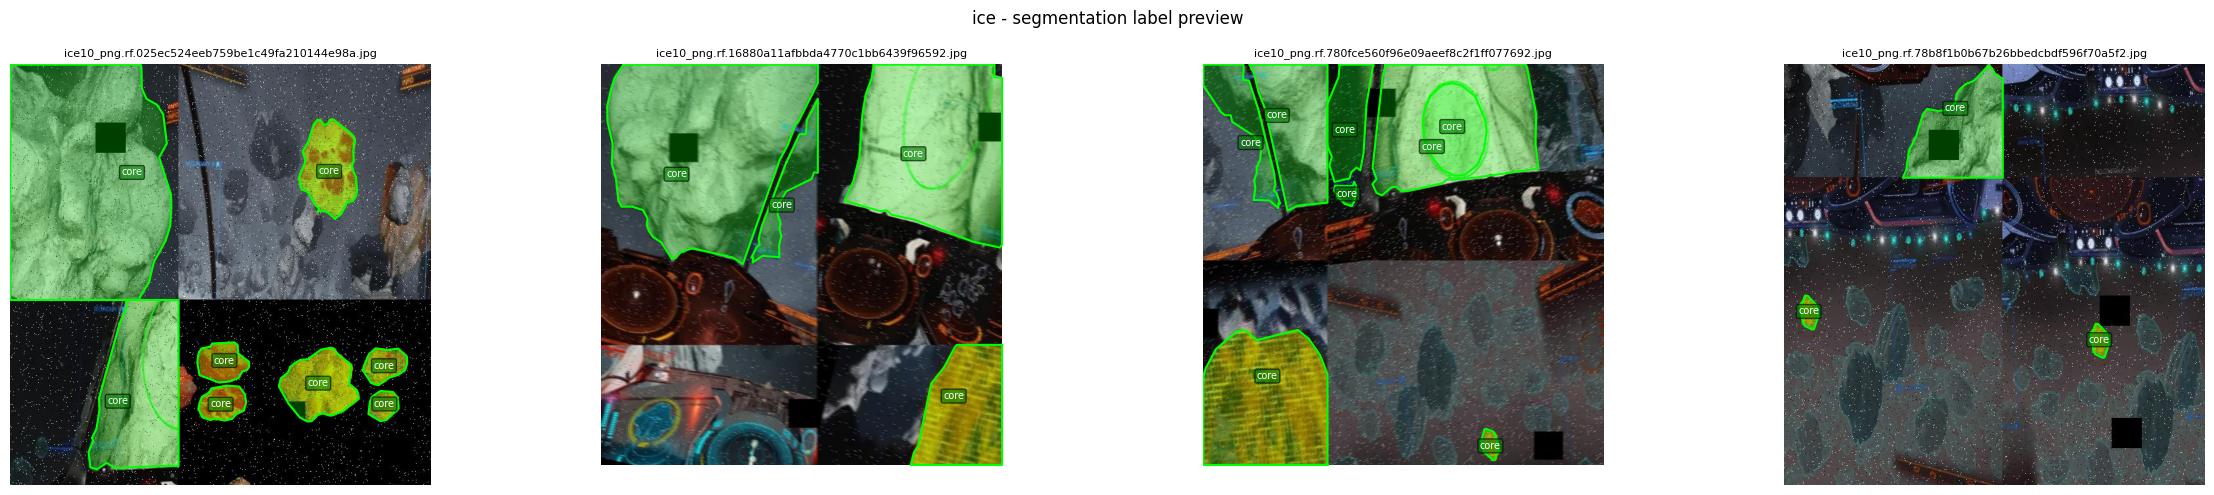

In [13]:
def preview_labels(ring_type, n=4):
    """
    Show the first n labeled images with segmentation polygons drawn on them.
    Each core gets a filled semi-transparent polygon plus its outline.
    """
    img_dir = DATASET_ROOT / ring_type / "images"
    lbl_dir = DATASET_ROOT / ring_type / "labels"

    images = sorted(list(img_dir.glob("*.png")) + list(img_dir.glob("*.jpg")))[:n]
    if not images:
        print(f"No images found in {img_dir}")
        return

    cols = min(len(images), 4)
    rows = math.ceil(len(images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))

    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = list(axes.flat)
    else:
        axes = [ax for row in axes for ax in row]

    for i, ax in enumerate(axes):
        if i >= len(images):
            ax.axis("off")
            continue

        img_path = images[i]
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        H, W = img.shape[:2]

        ax.imshow(img)

        lbl_path = lbl_dir / (img_path.stem + ".txt")
        if lbl_path.exists():
            patches = []
            for line in lbl_path.read_text().strip().splitlines():
                parts = line.strip().split()
                if len(parts) < 7:
                    continue
                coords = [float(v) for v in parts[1:]]
                # convert normalized pairs to pixel coordinates
                pts = np.array([
                    [coords[j] * W, coords[j + 1] * H]
                    for j in range(0, len(coords) - 1, 2)
                ])
                poly = MplPolygon(pts, closed=True)
                patches.append(poly)
                # draw outline
                ax.plot(
                    np.append(pts[:, 0], pts[0, 0]),
                    np.append(pts[:, 1], pts[0, 1]),
                    color="lime", linewidth=1.5
                )
                # label at centroid
                cx, cy = pts[:, 0].mean(), pts[:, 1].mean()
                ax.text(cx, cy, "core", color="white", fontsize=7,
                        ha="center", va="center",
                        bbox=dict(boxstyle="round,pad=0.2", fc="green", alpha=0.6))

            if patches:
                pc = PatchCollection(patches, alpha=0.25, facecolor="lime", edgecolor="none")
                ax.add_collection(pc)

        ax.set_title(img_path.name, fontsize=8)
        ax.axis("off")

    plt.suptitle(f"{ring_type} - segmentation label preview", fontsize=12)
    plt.tight_layout()
    plt.show()


preview_labels("ice", n=4)


## 8. K-fold cross-validation helpers

Same approach as before: build temporary per-fold datasets using hard links,
write a data.yaml per fold, train, then clean up. No extra disk space used.


In [14]:
def get_paired_samples(ring_type):
    """
    Return (pairs, groups) for a ring type.

    pairs: sorted list of (image_path, label_path) for every labeled image.
    groups: list of lists of indices into pairs, where each inner list holds
            all indices that belong to the same source image (i.e. the source
            plus all its Roboflow-augmented variants). Used by train_kfold to
            prevent augmented copies of the same source from appearing in both
            train and val at the same time.

    Group membership is read from aug_groups.json written by
    import_roboflow_export(). If that file doesn't exist, every image is
    treated as its own group (standard k-fold with no grouping constraint).
    """
    from collections import defaultdict as _dd
    img_dir = DATASET_ROOT / ring_type / "images"
    lbl_dir = DATASET_ROOT / ring_type / "labels"
    pairs = []
    for img_path in sorted(
        list(img_dir.glob("*.png"))
        + list(img_dir.glob("*.jpg"))
        + list(img_dir.glob("*.jpeg"))
    ):
        lbl_path = lbl_dir / (img_path.stem + ".txt")
        if lbl_path.exists():
            pairs.append((img_path, lbl_path))

    groups_path = DATASET_ROOT / ring_type / "aug_groups.json"
    if groups_path.exists():
        with open(groups_path) as f:
            aug_groups = json.load(f)
        stem_to_group = {
            stem: group_key
            for group_key, stems in aug_groups.items()
            for stem in stems
        }
        group_to_indices = _dd(list)
        for idx, (img_path, _) in enumerate(pairs):
            gk = stem_to_group.get(img_path.stem, img_path.stem)
            group_to_indices[gk].append(idx)
        groups = list(group_to_indices.values())
    else:
        groups = [[i] for i in range(len(pairs))]

    return pairs, groups


def build_fold_dataset(pairs_train, pairs_val, fold_dir):
    """
    Build a temporary YOLO dataset for one fold using hard links.
    Falls back to file copy if the filesystem doesn't support hard links.
    """
    def link_or_copy(src, dst):
        dst.parent.mkdir(parents=True, exist_ok=True)
        if dst.exists():
            dst.unlink()
        try:
            os.link(src, dst)
        except OSError:
            shutil.copy2(src, dst)

    for split, pairs in [("train", pairs_train), ("val", pairs_val)]:
        for img_path, lbl_path in pairs:
            link_or_copy(img_path, fold_dir / "images" / split / img_path.name)
            link_or_copy(lbl_path, fold_dir / "labels" / split / lbl_path.name)


def write_fold_yaml(fold_dir):
    """Write data.yaml pointing YOLO at this fold's train/val folders."""
    yaml_path = fold_dir / "data.yaml"
    with open(yaml_path, "w") as f:
        yaml.dump({
            "path":  str(fold_dir.resolve()),
            "train": "images/train",
            "val":   "images/val",
            "nc":    len(CLASS_NAMES),
            "names": CLASS_NAMES,
        }, f, default_flow_style=False)
    return yaml_path


def cleanup_fold(fold_dir):
    """Delete temporary fold dataset after training is done."""
    if fold_dir.exists():
        shutil.rmtree(fold_dir)


In [21]:
def train_one_fold(yaml_path, run_name, model_size, n_train, n_val):
    """
    Train one YOLOv8-seg model on a prepared fold dataset.

    Segmentation models output both a bounding box head and a mask head.
    We track both box-mAP (mAP50(B)) and mask-mAP (mAP50(M)) in results.

    Returns:
        (weights_path str, metrics dict)
    """
    print(f"  Training {run_name}  (train={n_train}, val={n_val})")

    model = YOLO(f"{model_size}.pt")

    results = model.train(
        data=str(yaml_path),
        epochs=EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        patience=PATIENCE,
        device=0 if torch.cuda.is_available() else "cpu",
        project=str(RUNS_ROOT),
        name=run_name,

        # -- Augmentation tuned for Elite Dangerous screenshots --
        # Asteroids rotate at all angles - heavy rotation is always valid
        degrees=45,
        # Horizontal/vertical flips are valid in zero-g environments
        fliplr=0.5,
        flipud=0.3,
        # Cores appear at different distances = different apparent sizes on screen
        scale=0.5,
        # Mosaic helps the model handle cluttered asteroid fields
        mosaic=1.0,
        close_mosaic=10,
        # Brightness and saturation shift for star-lit vs shadow-side-of-planet lighting
        hsv_v=0.4,
        hsv_s=0.5,
        # Small hue shift - ring types differ somewhat but not wildly
        hsv_h=0.015,
        # Game renders are sharp - skip blur augmentations
        blur=False,
        median_blur=0.0,

        save_period=0,   # skip intermediate checkpoints to save disk space
        verbose=False,
    )

    rd = results.results_dict
    weights = RUNS_ROOT / run_name / "weights" / "best.pt"

    metrics = {
        # box metrics (bounding box head)
        "box_mAP50":    float(rd.get("metrics/mAP50(B)",     0)),
        "box_mAP50_95": float(rd.get("metrics/mAP50-95(B)",  0)),
        "precision":    float(rd.get("metrics/precision(B)", 0)),
        "recall":       float(rd.get("metrics/recall(B)",    0)),
        # mask metrics (segmentation head) - the primary metric for seg models
        "mask_mAP50":    float(rd.get("metrics/mAP50(M)",    0)),
        "mask_mAP50_95": float(rd.get("metrics/mAP50-95(M)", 0)),
    }

    print(
        f"    -> box mAP50={metrics['box_mAP50']:.3f}  "
        f"mask mAP50={metrics['mask_mAP50']:.3f}  "
        f"P={metrics['precision']:.3f}  R={metrics['recall']:.3f}"
    )
    return str(weights), metrics


## 9. Train segmentation models with k-fold cross-validation

For each ring type x model size combination:
1. Split all images into K folds
2. Train K models (each validated on a different held-out chunk)
3. Average both box-mAP and mask-mAP across folds
4. Keep the best fold's weights as the deployed model

**Mask mAP50** is the primary metric for segmentation - it measures how well the
predicted polygon overlaps with your labeled polygon. Box mAP50 is the secondary
metric from the detection head (still useful for knowing if the model finds the
asteroid at all, even if the mask shape isn't perfect).

Rough timing on RTX 3070:
- yolov8n-seg: ~5 min/fold
- yolov8s-seg: ~10 min/fold
- yolov8m-seg: ~20 min/fold
- yolov8l-seg: ~35 min/fold


In [22]:
def train_kfold(ring_type, model_size):
    """
    Run K-fold cross-validation for one ring type + model size combination.
    Best fold is selected by mask_mAP50 (the primary seg metric).
    Returns a result dict or None if not enough data.
    """
    pairs, groups = get_paired_samples(ring_type)

    if len(groups) < K_FOLDS:
        print(f"Skipping {ring_type}/{model_size}: only {len(groups)} source groups "
              f"(need >= {K_FOLDS} for {K_FOLDS} folds, total images: {len(pairs)}).")
        return None

    print(f"\n{'=' * 60}")
    print(f"  {ring_type.upper()} / {model_size}  "
          f"({len(pairs)} images, {len(groups)} source groups, {K_FOLDS} folds)")
    print(f"{'=' * 60}")

    kf          = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
    pairs_arr   = np.array(pairs, dtype=object)
    groups_arr  = np.array(groups, dtype=object)
    timestamp   = datetime.now().strftime("%Y%m%d_%H%M%S")
    fold_results = []

    # split over groups so all augmented variants of one source stay together
    for fold_idx, (train_group_idx, val_group_idx) in enumerate(kf.split(groups_arr)):
        fold_num      = fold_idx + 1
        train_img_idx = [i for gi in train_group_idx for i in groups_arr[gi]]
        val_img_idx   = [i for gi in val_group_idx   for i in groups_arr[gi]]
        pairs_train   = pairs_arr[train_img_idx].tolist()
        pairs_val     = pairs_arr[val_img_idx].tolist()

        fold_dir = CV_TMP_ROOT / f"{ring_type}_{model_size}_fold{fold_num}"
        run_name = f"{ring_type}_{model_size}_fold{fold_num}_{timestamp}"

        print(f"\nFold {fold_num}/{K_FOLDS}")
        build_fold_dataset(pairs_train, pairs_val, fold_dir)
        yaml_path = write_fold_yaml(fold_dir)

        weights, metrics = train_one_fold(
            yaml_path, run_name, model_size, len(pairs_train), len(pairs_val)
        )
        fold_results.append({"fold": fold_num, "weights": weights, **metrics})
        cleanup_fold(fold_dir)

    def avg(key):
        return float(np.mean([r[key] for r in fold_results]))

    def std(key):
        return float(np.std([r[key] for r in fold_results]))

    # best fold selected by mask mAP50 (primary seg metric)
    best_fold = max(fold_results, key=lambda r: r["mask_mAP50"])

    summary = {
        "best_weights":    best_fold["weights"],
        "best_fold":       best_fold["fold"],
        "fold_results":    fold_results,
        "box_mAP50":       avg("box_mAP50"),
        "box_mAP50_95":    avg("box_mAP50_95"),
        "mask_mAP50":      avg("mask_mAP50"),
        "mask_mAP50_95":   avg("mask_mAP50_95"),
        "precision":       avg("precision"),
        "recall":          avg("recall"),
        "mask_mAP50_std":  std("mask_mAP50"),
        "box_mAP50_std":   std("box_mAP50"),
    }

    print(f"\nAverage across {K_FOLDS} folds:")
    print(
        f"  box  mAP50={summary['box_mAP50']:.3f} (+/-{summary['box_mAP50_std']:.3f})"
    )
    print(
        f"  mask mAP50={summary['mask_mAP50']:.3f} (+/-{summary['mask_mAP50_std']:.3f})  "
        f"<-- primary metric"
    )
    print(
        f"  P={summary['precision']:.3f}  R={summary['recall']:.3f}  "
        f"best fold: {best_fold['fold']}"
    )
    return summary


In [23]:
# Run all ring type x model size combinations.
# Skips any ring type that doesn't have enough data yet.

all_results = {}

for ring_type in RING_TYPES:
    stats, issues = validate_dataset(ring_type)
    if issues:
        print(f"Skipping {ring_type} - fix dataset issues first:")
        for iss in issues:
            print(f"  {iss}")
        continue
    if stats["paired"] < K_FOLDS * 2:
        print(f"Skipping {ring_type} - not enough images ({stats['paired']}).")
        continue

    all_results[ring_type] = {}
    for model_size in MODEL_SIZES:
        result = train_kfold(ring_type, model_size)
        if result is not None:
            all_results[ring_type][model_size] = result

results_path = RUNS_ROOT / "all_results.json"
RUNS_ROOT.mkdir(exist_ok=True)
with open(results_path, "w") as f:
    json.dump(all_results, f, indent=2)

print("\nAll training runs complete. Results saved to:", results_path)


  ICE dataset
  Images:              17
  Paired (img+label):  17
  Total core polygons: 44
  Avg cores/image:     2.59
  All checks passed.

  ICE / yolov8n-seg  (17 images, 3 folds)

Fold 1/3
  Training ice_yolov8n-seg_fold1_20260221_095539  (train=11, val=6)


SyntaxError: '[31m[1mmedian_blur[0m' is not a valid YOLO argument. 
'[31m[1mblur[0m' is not a valid YOLO argument. 

    Arguments received: ['yolo', '-f', 'C:\\Users\\megakruk\\AppData\\Roaming\\jupyter\\runtime\\kernel-8ca177d4-5143-467d-be56-a2039b69b512.json']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of ['classify', 'pose', 'obb', 'segment', 'detect']
                MODE (required) is one of ['track', 'val', 'train', 'predict', 'benchmark', 'export']
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at https://docs.ultralytics.com/usage/cfg or with 'yolo cfg'

    1. Train a detection model for 10 epochs with an initial learning_rate of 0.01
        yolo train data=coco8.yaml model=yolo26n.pt epochs=10 lr0=0.01

    2. Predict a YouTube video using a pretrained segmentation model at image size 320:
        yolo predict model=yolo26n-seg.pt source='https://youtu.be/LNwODJXcvt4' imgsz=320

    3. Validate a pretrained detection model at batch-size 1 and image size 640:
        yolo val model=yolo26n.pt data=coco8.yaml batch=1 imgsz=640

    4. Export a YOLO26n classification model to ONNX format at image size 224 by 128 (no TASK required)
        yolo export model=yolo26n-cls.pt format=onnx imgsz=224,128

    5. Ultralytics solutions usage
        yolo solutions count or any of ['crop', 'blur', 'workout', 'heatmap', 'isegment', 'visioneye', 'speed', 'queue', 'analytics', 'inference', 'trackzone'] source="path/to/video.mp4"

    6. Run special commands:
        yolo help
        yolo checks
        yolo version
        yolo settings
        yolo copy-cfg
        yolo cfg
        yolo solutions help

    Docs: https://docs.ultralytics.com
    Solutions: https://docs.ultralytics.com/solutions/
    Community: https://community.ultralytics.com
    GitHub: https://github.com/ultralytics/ultralytics
     (<string>)

## 10. Compare model results

Both box mAP50 and mask mAP50 are shown. Mask mAP50 is what matters for segmentation quality - it measures polygon overlap with your ground truth labels.

In [ ]:
def show_comparison_table():
    """
    Print a formatted table of all trained model metrics.
    Shows both box and mask mAP50 with standard deviation across folds.
    Best model per ring type is selected by mask_mAP50.
    """
    results_path = RUNS_ROOT / "all_results.json"
    if not results_path.exists():
        print("No results yet - run training first.")
        return {}

    with open(results_path) as f:
        results = json.load(f)

    header = (
        f"{'Ring':<12} {'Model':<16} "
        f"{'boxmAP50':>9} {'  +/-':>6} "
        f"{'mskMAP50':>9} {'  +/-':>6} "
        f"{'Prec':>7} {'Recall':>7}"
    )
    print(header)
    print("-" * len(header))

    best_per_ring = {}
    for ring_type, models in results.items():
        best_mask = -1
        for model_size, m in models.items():
            marker = ""
            if m["mask_mAP50"] > best_mask:
                best_mask = m["mask_mAP50"]
                best_per_ring[ring_type] = model_size
                marker = "  <-- best"
            print(
                f"{ring_type:<12} {model_size:<16} "
                f"{m['box_mAP50']:>9.3f} {m.get('box_mAP50_std', 0):>6.3f} "
                f"{m['mask_mAP50']:>9.3f} {m.get('mask_mAP50_std', 0):>6.3f} "
                f"{m['precision']:>7.3f} {m['recall']:>7.3f}"
                + marker
            )
        print()

    return best_per_ring


best_models = show_comparison_table()
print("Best model per ring type:", best_models)


## 11. Plot per-fold metrics

High variance between folds = model is sensitive to which images land in val, which usually means you need more labeled data.

In [ ]:
def plot_fold_metrics(ring_type, model_size):
    """
    Bar chart of box mAP50 and mask mAP50 per fold side by side.
    Dashed lines show the mean across folds for each metric.
    """
    results_path = RUNS_ROOT / "all_results.json"
    if not results_path.exists():
        print("No results found.")
        return

    with open(results_path) as f:
        all_r = json.load(f)

    model_data = all_r.get(ring_type, {}).get(model_size)
    if not model_data:
        print(f"No data for {ring_type}/{model_size}")
        return

    fold_results = model_data.get("fold_results", [])
    if not fold_results:
        print("No per-fold results stored.")
        return

    folds      = [f"Fold {r['fold']}" for r in fold_results]
    box_maps   = [r["box_mAP50"]  for r in fold_results]
    mask_maps  = [r["mask_mAP50"] for r in fold_results]
    precs      = [r["precision"]  for r in fold_results]
    recs       = [r["recall"]     for r in fold_results]

    x = np.arange(len(folds))
    w = 0.2

    fig, ax = plt.subplots(figsize=(11, 5))
    ax.bar(x - 1.5*w, box_maps,  w, label="box mAP50",  color="steelblue")
    ax.bar(x - 0.5*w, mask_maps, w, label="mask mAP50", color="darkorange")
    ax.bar(x + 0.5*w, precs,     w, label="Precision",  color="seagreen")
    ax.bar(x + 1.5*w, recs,      w, label="Recall",     color="tomato")

    ax.axhline(np.mean(box_maps),  color="steelblue",  linestyle="--", linewidth=1.1,
               label=f"mean box={np.mean(box_maps):.3f}")
    ax.axhline(np.mean(mask_maps), color="darkorange",  linestyle="--", linewidth=1.1,
               label=f"mean mask={np.mean(mask_maps):.3f}")

    ax.set_xticks(x)
    ax.set_xticklabels(folds)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Score")
    ax.set_title(f"{ring_type} / {model_size} - metrics per fold")
    ax.legend(fontsize=8)
    ax.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_fold_metrics("ice", "yolov8s-seg")


## 12. Plot training curves for a specific fold

In [ ]:
def plot_training_curves(ring_type, model_size, fold=None):
    """
    Plot loss, box mAP50, and mask mAP50 curves from a run's results.csv.
    Defaults to the best fold if fold is not specified.
    """
    results_path = RUNS_ROOT / "all_results.json"
    if not results_path.exists():
        print("No results found.")
        return

    with open(results_path) as f:
        all_r = json.load(f)

    model_data = all_r.get(ring_type, {}).get(model_size)
    if not model_data:
        print(f"No data for {ring_type}/{model_size}")
        return

    if fold is None:
        fold = model_data["best_fold"]
        print(f"Plotting best fold: {fold}")

    weights_path = next(
        (r["weights"] for r in model_data["fold_results"] if r["fold"] == fold), None
    )
    if not weights_path:
        print(f"Fold {fold} not found.")
        return

    csv_path = Path(weights_path).parent.parent / "results.csv"
    if not csv_path.exists():
        print(f"results.csv not found at {csv_path}")
        return

    epochs, seg_loss, box_loss, cls_loss, box_map50, mask_map50 = [], [], [], [], [], []
    with open(csv_path) as f:
        reader = csv.DictReader(f)
        for row in reader:
            row = {k.strip(): v.strip() for k, v in row.items()}
            epochs.append(int(row.get("epoch", 0)))
            # seg loss key varies slightly by ultralytics version
            seg_loss.append(float(
                row.get("train/seg_loss") or row.get("train/dfl_loss") or 0
            ))
            box_loss.append(float(row.get("train/box_loss") or 0))
            cls_loss.append(float(row.get("train/cls_loss") or 0))
            box_map50.append(float(row.get("metrics/mAP50(B)") or 0))
            mask_map50.append(float(row.get("metrics/mAP50(M)") or 0))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

    ax1.plot(epochs, seg_loss,  label="seg loss")
    ax1.plot(epochs, box_loss,  label="box loss")
    ax1.plot(epochs, cls_loss,  label="cls loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title(f"{ring_type} / {model_size} fold {fold} - training losses")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(epochs, box_map50,  label="box mAP50",  color="steelblue")
    ax2.plot(epochs, mask_map50, label="mask mAP50", color="darkorange", linewidth=2)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("mAP50")
    ax2.set_title(f"{ring_type} / {model_size} fold {fold} - validation mAP50")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_training_curves("ice", "yolov8s-seg")


## 13. Test inference on a screenshot

Runs the segmentation model and draws filled polygon masks over detected cores with confidence scores.

In [ ]:
def detect_cores(image_path, ring_type, model_size=None, conf=CONF_THRESHOLD):
    """
    Run the trained segmentation model on a single screenshot.
    Draws filled polygon masks over each detected core.

    Args:
        image_path: path to a .png or .jpg screenshot
        ring_type:  which ring type model to load
        model_size: e.g. "yolov8s-seg", or None to auto-pick best mask mAP50
        conf:       confidence threshold
    """
    results_path = RUNS_ROOT / "all_results.json"
    if not results_path.exists():
        print("No trained models found. Run training first.")
        return

    with open(results_path) as f:
        all_r = json.load(f)

    ring_models = all_r.get(ring_type, {})
    if not ring_models:
        print(f"No trained model for ring type '{ring_type}'.")
        return

    if model_size is None:
        model_size = max(ring_models, key=lambda m: ring_models[m]["mask_mAP50"])
        m = ring_models[model_size]
        print(
            f"Auto-selected: {model_size} "
            f"(mask mAP50={m['mask_mAP50']:.3f}, box mAP50={m['box_mAP50']:.3f})"
        )

    weights = ring_models.get(model_size, {}).get("best_weights", "")
    if not weights or not Path(weights).exists():
        print(f"Weights file not found: {weights}")
        return

    model = YOLO(weights)
    img   = cv2.imread(str(image_path))
    if img is None:
        print(f"Could not load image: {image_path}")
        return

    preds = model.predict(img, conf=conf, verbose=False)[0]

    # draw masks manually so we control colors and alpha
    img_rgb   = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()
    overlay   = img_rgb.copy()
    H, W      = img_rgb.shape[:2]

    if preds.masks is not None:
        for i, mask_data in enumerate(preds.masks.xy):
            pts = mask_data.astype(np.int32)
            cv2.fillPoly(overlay, [pts], color=MASK_COLOR_BGR[::-1])  # BGR->RGB

        cv2.addWeighted(overlay, MASK_ALPHA, img_rgb, 1 - MASK_ALPHA, 0, img_rgb)

        # draw polygon outlines and confidence labels on top
        for i, (mask_data, box) in enumerate(zip(preds.masks.xy, preds.boxes)):
            pts  = mask_data.astype(np.int32)
            conf_val = float(box.conf)
            cv2.polylines(img_rgb, [pts], isClosed=True, color=(0, 255, 80), thickness=2)
            cx = int(pts[:, 0].mean())
            cy = int(pts[:, 1].mean())
            label = f"core {conf_val:.2f}"
            cv2.putText(img_rgb, label, (cx - 30, cy),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    plt.figure(figsize=(14, 8))
    plt.imshow(img_rgb)
    n = len(preds.boxes)
    plt.title(f"{ring_type} | {model_size} | {n} core(s) detected | conf>={conf}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    print(f"Detections: {n}")
    for box in preds.boxes:
        xyxy = [round(v, 1) for v in box.xyxy[0].tolist()]
        print(f"  core | conf={float(box.conf):.3f} | bbox={xyxy}")

    return preds


# Usage:
# detect_cores("screenshot.png", ring_type="ice")
# detect_cores("screenshot.png", ring_type="metallic", model_size="yolov8m-seg")


## 14. One-button retrain

Drop new labeled screenshots into the dataset folder and call `retrain()`.

In [ ]:
def retrain(ring_type="all", model_size="best"):
    """
    Retrain after adding new labeled screenshots.
    Drop new images + label files into datasets/<ring_type>/images/ and labels/,
    then call this.

    Args:
        ring_type:  "all" retrains every type, or pass one e.g. "ice"
        model_size: "best" reuses the size that scored highest last time by
                    mask_mAP50, or pass a specific size like "yolov8m-seg"
    """
    targets = RING_TYPES if ring_type == "all" else [ring_type]

    results_path = RUNS_ROOT / "all_results.json"
    prev_results = {}
    if results_path.exists():
        with open(results_path) as f:
            prev_results = json.load(f)

    for rt in targets:
        stats, issues = validate_dataset(rt)
        if issues:
            print(f"Dataset issues for '{rt}':")
            for iss in issues:
                print(f"  {iss}")
            continue

        if stats["source_groups"] < K_FOLDS:
            print(f"Skipping '{rt}' - only {stats['source_groups']} source groups, "
                  f"need >= {K_FOLDS} for k-fold.")
            continue

        if model_size == "best":
            ring_prev = prev_results.get(rt, {})
            size = (
                max(ring_prev, key=lambda m: ring_prev[m]["mask_mAP50"])
                if ring_prev else "yolov8s-seg"
            )
            print(f"Using best model size from previous run: {size}")
        else:
            size = model_size

        result = train_kfold(rt, size)
        if result is not None:
            if rt not in prev_results:
                prev_results[rt] = {}
            prev_results[rt][size] = result

    with open(results_path, "w") as f:
        json.dump(prev_results, f, indent=2)

    print("\nRetrain complete!")
    show_comparison_table()


# Examples:
# retrain()                          # all ring types, best model size each
# retrain("ice")                     # only ice, auto-pick best size
# retrain("ice", "yolov8l-seg")      # force a specific model size


## 15. Export best models to ONNX

In [ ]:
def export_best_models():
    """
    Export the best fold's weights for each ring type to ONNX format.
    Best is chosen by mask_mAP50. Output goes to exports/<ring_type>_best.onnx
    """
    results_path = RUNS_ROOT / "all_results.json"
    if not results_path.exists():
        print("No trained models to export.")
        return

    with open(results_path) as f:
        all_r = json.load(f)

    EXPORTS_ROOT.mkdir(exist_ok=True)

    for ring_type, models in all_r.items():
        if not models:
            continue

        best_size    = max(models, key=lambda m: models[m]["mask_mAP50"])
        best_weights = models[best_size]["best_weights"]

        if not Path(best_weights).exists():
            print(f"Weights missing for {ring_type}/{best_size}: {best_weights}")
            continue

        m = models[best_size]
        print(
            f"Exporting {ring_type} ({best_size}) "
            f"mask mAP50={m['mask_mAP50']:.3f} box mAP50={m['box_mAP50']:.3f}..."
        )
        model    = YOLO(best_weights)
        exported = model.export(
            format="onnx",
            imgsz=IMG_SIZE,
            simplify=True,
            opset=17,
            dynamic=False,
        )

        dest    = EXPORTS_ROOT / f"{ring_type}_best.onnx"
        shutil.copy(exported, dest)
        print(f"  -> {dest}  ({dest.stat().st_size / 1024 / 1024:.1f} MB)")

    print("\nExport complete. Files are in:", EXPORTS_ROOT)


export_best_models()


## 16. Batch inference on a folder of screenshots

In [ ]:
def batch_detect(screenshots_folder, ring_type, output_folder=None, conf=CONF_THRESHOLD):
    """
    Run segmentation detection on every image in a folder and save annotated copies.
    Annotated copies have filled polygon masks drawn over detected cores.

    Args:
        screenshots_folder: folder with .png/.jpg screenshots
        ring_type:          which ring type model to use
        output_folder:      where to save annotated images (default: screenshots_folder/detected)
        conf:               confidence threshold
    """
    screenshots_folder = Path(screenshots_folder)
    output_folder = Path(output_folder or screenshots_folder / "detected")
    output_folder.mkdir(exist_ok=True)

    results_path = RUNS_ROOT / "all_results.json"
    if not results_path.exists():
        print("No trained models. Run training first.")
        return

    with open(results_path) as f:
        all_r = json.load(f)

    ring_models = all_r.get(ring_type, {})
    if not ring_models:
        print(f"No model for ring type '{ring_type}'")
        return

    best_size    = max(ring_models, key=lambda m: ring_models[m]["mask_mAP50"])
    best_weights = ring_models[best_size]["best_weights"]
    model        = YOLO(best_weights)

    images = sorted(list(screenshots_folder.glob("*.png")) + list(screenshots_folder.glob("*.jpg") + list(screenshots_folder.glob("*.jpeg")))
    print(f"Running {best_size} ({ring_type}) on {len(images)} images...")

    total_cores = 0
    for img_path in images:
        img   = cv2.imread(str(img_path))
        preds = model.predict(img, conf=conf, verbose=False)[0]

        # preds.plot() renders masks + boxes + labels into one annotated image
        annotated = preds.plot()
        cv2.imwrite(str(output_folder / img_path.name), annotated)
        total_cores += len(preds.boxes)

    print(f"Done. {total_cores} total core detections across {len(images)} screenshots.")
    print(f"Annotated images saved to: {output_folder}")


# Usage:
# batch_detect(
#     screenshots_folder=r"C:/Users/YourName/Pictures/Frontier Developments/Elite Dangerous",
#     ring_type="ice",
# )
